In [95]:
import os
import sys
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils

In [96]:
#define some basic functions here, like xcorr and etc

@nb.njit()
def get_common_rows(specnum0,specnum1,idxstart0,idxstart1):
    nrows0,nrows1=specnum0.shape[0],specnum1.shape[0]
    maxrows=min(nrows0,nrows1)
    rownums0=np.empty(maxrows,dtype='int64')
    rownums0[:]=-1
    rownums1=rownums0.copy()
    rowidx=rownums0.copy()
    i=0;j=0;row_count=0;
    while i<nrows0 and j<nrows1:
        if (specnum0[i]-idxstart0)==(specnum1[j]-idxstart1):
            rownums0[row_count]=i
            rownums1[row_count]=j
            rowidx[row_count]=specnum0[i]-idxstart0
            i+=1
            j+=1
            row_count+=1
        elif (specnum0[i]-idxstart0)>(specnum1[j]-idxstart1):
            j+=1
        else:
            i+=1
    return row_count,rownums0,rownums1,rowidx

@nb.njit(parallel=True)
def avg_xcorr_4bit_2ant_float(pol0,pol1,specnum0,specnum1,idxstart0,idxstart1,delay=None,freqs=None):
    row_count,rownums0,rownums1,rowidx=get_common_rows(specnum0,specnum1,idxstart0,idxstart1)
    ncols=pol0.shape[1]
#     print("ncols",ncols)
    assert pol0.shape[1]==pol1.shape[1]
    xcorr=np.zeros((row_count,ncols),dtype='complex64') # in the dev_gen_phases branch
    if delay is not None:
        for i in nb.prange(row_count):
            for j in range(ncols):
                xcorr[i,j] = pol0[rownums0[i],j]*np.conj(pol1[rownums1[i],j]*np.exp(2j*np.pi*delay[rowidx[i]]*freqs[j]))
    else:
        for i in nb.prange(row_count):
            xcorr[i,:] = pol0[rownums0[i],:]*np.conj(pol1[rownums1[i],:])
    return xcorr

def get_coarse_xcorr(f1, f2, Npfb=4096):
    if len(f1.shape) == 1:
        f1 = f1.reshape(-1, 1)
    if len(f2.shape) == 1:
        f2 = f2.reshape(-1, 1)
    chans = f1.shape[1]
    Nsmall = f1.shape[0]
    wt = np.zeros(2 * Nsmall)
    wt[:Nsmall] = 1
    n_avg = np.fft.irfft(np.fft.rfft(wt) * np.conj(np.fft.rfft(wt)))
#     print(n_avg)
#     n_avg[Nsmall] = np.nan
#     print(n_avg[Nsmall-10:Nsmall+10])
    n_avg = np.tile(n_avg, chans).reshape(chans, 2*Nsmall)
#     print(n_avg.shape)
    bigf1 = np.vstack([f1, np.zeros(f1.shape, dtype=f1.dtype)])
    bigf2 = np.vstack([f2, np.zeros(f2.shape, dtype=f2.dtype)])
    bigf1 = bigf1.T.copy()
    bigf2 = bigf2.T.copy()
    bigf1f = np.fft.fft(bigf1,axis=1)
    bigf2f = np.fft.fft(bigf2,axis=1)
    xx = bigf1f * np.conj(bigf2f)
    xcorr = np.fft.ifft(xx,axis=1)
    xcorr = xcorr / n_avg
    xcorr[:,Nsmall] = np.nan
    return xcorr


<h1 style="font-size:30pt">Setup (Part 0)</h1>

In [97]:
#spectrum interval (aka period) (4096 point FFT, 250M sampling rate)
T_SPECTRA = 4096/250e6

#start and end times
#for now, an hour of data
t_start = 1721800002 + 1000*5
t_end = t_start+3600

#use "get_init_info" to get the files and spectrum numbers needed for our time interval
a1_path = "/scratch/s/sievers/mohanagr/mars1_2024/baseband/"
a2_path = "/scratch/s/sievers/mohanagr/mars2_2024/baseband/"
files_a1, idx1 = butils.get_init_info(t_start, t_end, a1_path)
files_a2, idx2 = butils.get_init_info(t_start, t_end, a2_path)
print(files_a1)
print(files_a2)
print("Uncorrected Starting Indices:", idx1, idx2)

'''
I believe this is where we use the satellite detection script to tell us lots of stuff.
We need to do a coarse correlation to get the starting index offset, to get decent visibilities.
We then also need to detect which satellite passes we can use to fit our data.

the rest of this cell is just to get this thing to run for the time being.
'''

#so this part was first found by hand-wavy coarse correlation and offset (for debugging purposes)
#thus here we pretend by magic we know, and in the future we do with the proper script
idx_correction=109993-100000
if idx_correction>0:
    idx1+=idx_correction
else:
    idx2+=np.abs(idx_correction)
print("Corrected Starting Indices:", idx1, idx2)

#get channel indices between 1834 and 1854, where we think we will find satellites
channels = bdc.get_header(files_a1[0])["channels"].astype('int64')
chanstart = np.where(channels == 1834)[0][0] 
chanend = np.where(channels == 1852)[0][0]
#total number of channels
nchans=chanend-chanstart 

#set the accumulation length for chunks (how many spectra per chunk)
#recall that to get visibilities, we want small acclen, for coarse xcorr we want large acclen
acclen= 30000 
#acclen= 3000000

#time taken for one full chunk 
T_ACCLEN = acclen*4096/250e6 
#how many total chunks for the time interval we care about
nchunks = int((t_end-t_start)/T_ACCLEN)


['/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721804973.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805018.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805062.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805106.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805151.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805195.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805240.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805284.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805328.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805373.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805417.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805462.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805506.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/17218055

<h1 style="font-size:30pt">Satellite Stuff (Part 1)</h1>

Here we kind of mimick what the satellite detection script is doing.
This should (in an ideal world) run by itself.

In [98]:
#get the TLE file for satellite pass information, for the file with starting time start_file_time
tle_path = outils.get_tle_file(start_file_time, "/project/s/sievers/mohanagr/OCOMM_TLES")

#now set up the risen sats 
dt=5
niter=3600*24//dt
alititude_cutoff=15
rsats = outils.get_risen_sats(tle_path, a1_coords, start_file_time, dt=dt, niter=niter,altitude_cutoff=alititude_cutoff)

starting at  1721800002 dt is 5


Text(0.5, 0, 'sec')

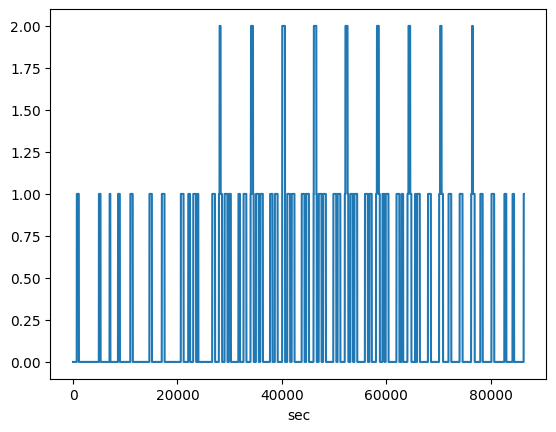

In [99]:
#a plot of how many satellites are risen 

#this gives a list of how many satellites are risen, where each entry represents a time interval
num_sats_risen = [len(x) for x in rsats]
#then you just plot it, noting that we have to multiply by 5 since that is our "dt" for the get_risen_sats
#i.e. the rate at which we measure how many sats there are
plt.plot(np.arange(len(rsats))*5,num_sats_risen)
plt.xlabel("sec")
#plt.xlim(0,20000)

(0.0, 20000.0)

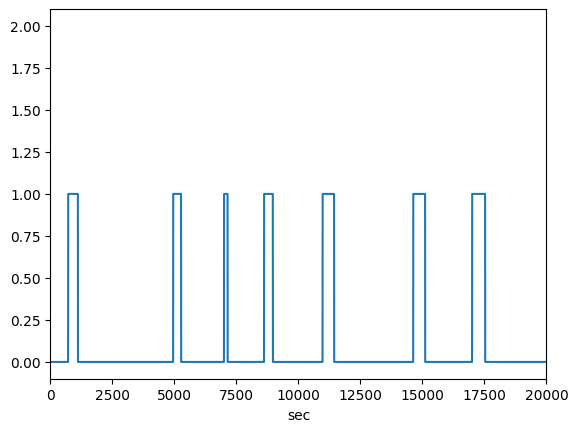

In [100]:
'''
same plot, but zoomed in
this is where he gets the 5*1000 initial timestamp from, because for the first chunk 
(which he uses to find the satellite offset) there is guaranteed to be only one satellite risen
you can clearly see this for the 5000 seconds (past 1721800002)
'''
num_sats_risen = [len(x) for x in rsats]
plt.plot(np.arange(len(rsats))*5,num_sats_risen)
plt.xlabel("sec")
plt.xlim(0,20000)

{44387, 59051, 57166, 28654, 33591, 25338}
[44387 59051 57166 28654 33591 25338]
{0: np.int64(44387), np.int64(44387): 0, 1: np.int64(59051), np.int64(59051): 1, 2: np.int64(57166), np.int64(57166): 2, 3: np.int64(28654), np.int64(28654): 3, 4: np.int64(33591), np.int64(33591): 4, 5: np.int64(25338), np.int64(25338): 5}


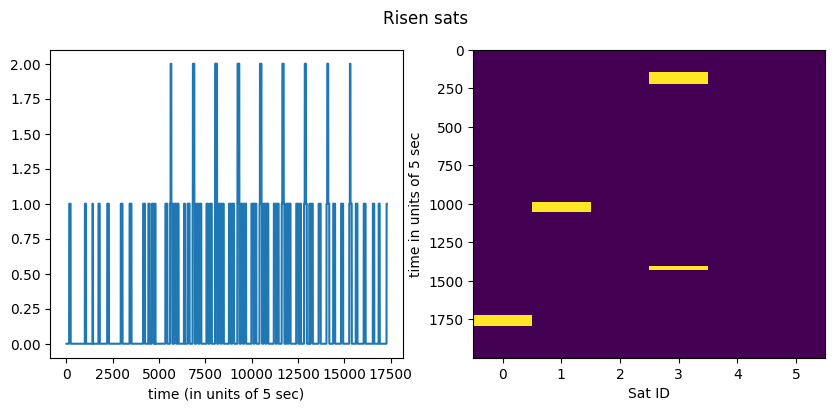

In [101]:
#satmap construction. Can see what satellites risen and when
num_sats_risen = [len(x) for x in rsats]
satnums=[]
for s in rsats:
    if len(s)>0:
        for j in range(len(s)):
            satnums.append(s[j][0])

satids = set(satnums)
print(satids)
satlist = (np.array(list(satids)))
print(satlist)
satmap = {}
assert min(satlist) > len(
    satlist
)  # to make sure there are no collisions, we'll never have an i that's also a satnum
for i, satnum in enumerate(satlist):
    satmap[i] = satnum
    satmap[satnum] = i
arr = np.zeros((len(rsats), len(satlist)), dtype="int64")
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10,4)
fig.suptitle(f"Risen sats")
ax[0].plot(num_sats_risen)
ax[0].set_xlabel("time (in units of 5 sec)")
for i, row in enumerate(rsats):
    for satnum, satele,sataz in row:
        arr[i][satmap[satnum]] = 1
ax[1].set_ylabel("time in units of 5 sec")
ax[1].set_xlabel("Sat ID")
ax[1].imshow(arr[:2000],aspect='auto',interpolation="none")

print(satmap)

<h1 style="font-size:30pt">Visibility Stuff (Part 2)</h1>

Now, once we have the predicted phase and have the index offset set up, we can find the observed phases. Recall that for now, this is only done for ONE satellite pass. We want to get to at least five passes, so in the streamlined code this will be done recursively.

In [102]:
#set up BaseBandFileIterator objects for both antenna
#this should be with the CORRECTED starting index though.

ant1=bdc.BasebandFileIterator(files_a1, 0, idx1, acclen, nchunks=nchunks, chanstart=chanstart, chanend=chanend, type='float')
ant2=bdc.BasebandFileIterator(files_a2, 0, idx2, acclen, nchunks=nchunks, chanstart=chanstart, chanend=chanend, type='float')

ACCLEN RECEIVED IS 30000
took 0.235 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721804973.raw
START SPECNUM IS 1294978843 obj start at 1293198830
ACCLEN RECEIVED IS 30000


took 1.408 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721804989.raw
START SPECNUM IS 1351222502 obj start at 1350429045


In [103]:
#getting visibility

m1=ant1.spec_num_start
m2=ant2.spec_num_start
visibility_phased = np.zeros((nchunks,len(ant1.channel_idxs)), dtype='complex64')
st=time.time()
for i, (chunk1,chunk2) in enumerate(zip(ant1,ant2)):
        # pol00[i,:] = cr.avg_xcorr_4bit_2ant(chunk1['pol0'], chunk2['pol0'],chnk1['specnums'],chunk2['specnums'],m1+i*acclen,m2+i*acclen)
        xcorr=avg_xcorr_4bit_2ant_float(chunk1['pol0'], chunk2['pol0'],chunk1['specnums'],chunk2['specnums'],m1+i*acclen,m2+i*acclen)
        visibility_phased[i,:] = np.sum(xcorr,axis=0)/acclen
        #print("CHUNK", i, " has ", xcorr.shape[0], " rows")
print("Time taken final:", time.time()-st)
visibility_phased = np.ma.masked_invalid(visibility_phased)


took 1.333 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805018.raw
took 1.418 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721805034.raw
took 1.340 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805062.raw
took 1.433 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721805078.raw
took 1.467 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805106.raw
took 1.399 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721805123.raw
took 1.361 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805151.raw
took 1.373 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721805167.raw
took 1.482 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805195.raw
took 1.468 seconds 

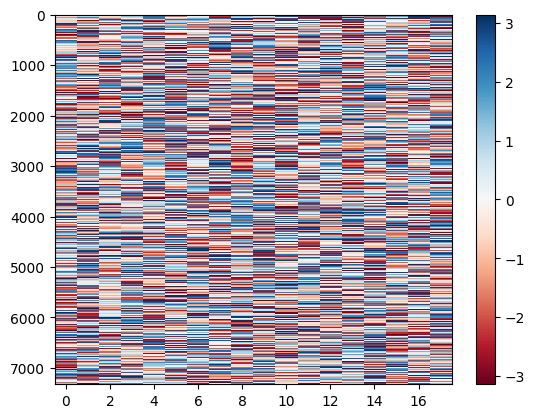

In [104]:
#plot visibility phase for the whole time
vis_phase = np.angle(visibility_phased)
# vis_phase_1clk = np.angle(visibility_1clk)
plt.imshow(vis_phase[:,:], aspect='auto',cmap='RdBu',interpolation="none")
plt.colorbar()

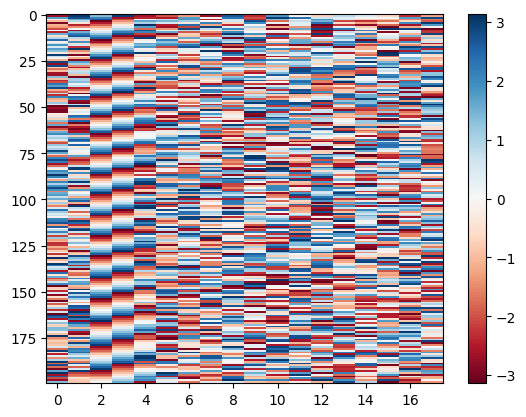

In [105]:
#for part of the time
vis_phase = np.angle(visibility_phased)
# vis_phase_1clk = np.angle(visibility_1clk)
plt.imshow(vis_phase[:200,:], aspect='auto',cmap='RdBu',interpolation="none")
plt.colorbar()

In [106]:
visibility_phased[:5,0]

masked_array(data=[(-0.007566666696220636-0.014433333650231361j),
                   (-0.031433332711458206-0.015233333222568035j),
                   (-0.007266666740179062+0.047066666185855865j),
                   (0.014833333902060986-0.004666666500270367j),
                   (0.01073333341628313-0.01626666635274887j)],
             mask=[False, False, False, False, False],
       fill_value=np.complex128(1e+20+0j),
            dtype=complex64)

In [107]:
t_start+3600*8.5

1721835602.0

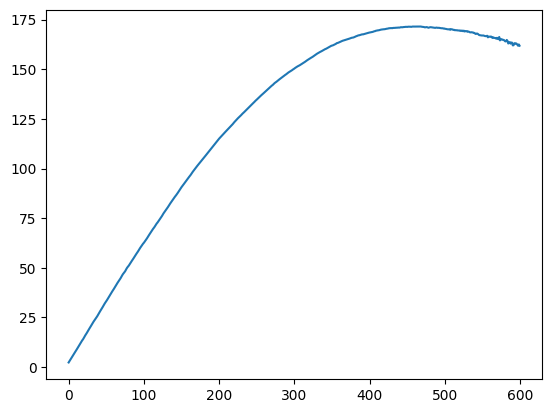

In [108]:
#plot visibility total
plt.plot(np.unwrap(vis_phase[0:600,3]))

In [2]:
1699711132 - 1699625045

86087